<a href="https://colab.research.google.com/github/TimStep/QManifold/blob/main/QManifold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q qiskit
!pip install -q pylatexenc #for mpl output
!pip install -q qiskit-machine-learning
#!pip install -q sparse
!pip install -q pennylane --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.8/97.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.

In [2]:
#default imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

#QML imports
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.connectors import TorchConnector
import pennylane as qml

In [3]:
RANDOM_SEED = 5678
torch.manual_seed(seed=RANDOM_SEED)
torch.cuda.manual_seed(seed=RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Dataset

In [5]:
[ds] = qml.data.load("other", name = "hidden-manifold")

In [6]:
def to_dataset(ds):
  HMtrainX = []
  HMtrainY = []
  HMtestX = []
  HMtestY = []
  for m in ds.train:
    HMtrainX += ds.train[m]['inputs']
    HMtrainY += ds.train[m]['labels']
    HMtestX = ds.test[m]['inputs']
    HMtestY = ds.test[m]['labels']
  return np.array(HMtrainX), np.array(HMtrainY), np.array(HMtestX), np.array(HMtestY)

In [7]:
HMtrainX, HMtrainY, HMtestX, HMtestY = to_dataset(ds)
HMtrainX.shape, HMtrainY.shape, HMtestX.shape, HMtestY.shape

((4560, 10), (4560,), (60, 10), (60,))

In [8]:
class ManifoldDataset(Dataset):
    def __init__(self, data_x, data_y):
        self.X = torch.tensor(data_x.astype('float32'))
        self.y = torch.tensor(data_y.astype('float32'))

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [9]:
HMtrainDS = ManifoldDataset(HMtrainX, HMtrainY)
HMtestDS = ManifoldDataset(HMtestX, HMtestY)
HMtrainDL = DataLoader(HMtrainDS, shuffle=True, drop_last=True, pin_memory=True, batch_size = 100)
HMtestDL = DataLoader(HMtestDS, shuffle=False)

# PQN

In [ ]:
class PQN():

    def __init__(self, qubits, repetitions, inputs=None, weights=None):

        if inputs is not None and len(inputs) != qubits:
          raise ValueError('Number of inputs doesnt align with number of qubits')

        self.qubits = qubits
        self.reps = repetitions

        self.weights = weights
        self.inputs = inputs
        self.gen_params()
        self.circuit = None
        self.gen_circuit()

        if self.weights is None or self.inputs is None or self.circuit is None:
          raise AttributeError('Weights, inputs or circuit is None')

    def gen_params(self):
      self.inputs = [Parameter("input" + str(i)) for i in range(1, self.qubits+1)] if self.inputs is None else self.inputs
      self.weights = [[Parameter("weight" + str(j) + str(i)) for i in range(1, 3*self.reps+1)] for j in range(1, self.qubits+1)] if self.weights is None else self.weights

    def gen_circuit(self):
      qc = QuantumCircuit(self.qubits)

      #encoding
      for q in range(self.qubits):
        qc.rx(self.inputs[q], q)

      for r in range(self.reps):
        #weighed gates
        for q in range(self.qubits):
          qc.rz(self.weights[q][r*3], q)
          qc.ry(self.weights[q][r*3+1], q)
          qc.rz(self.weights[q][r*3+2], q)

        #cnot gates
        for q in range(self.qubits-1):
          qc.cx(q, q+1)
        qc.cx(self.qubits-1, 0)

      self.circuit = qc

    def create_qnn(self):
      observables = []
      for q in range(self.qubits):
        s = ['I']*self.qubits
        s[q] = 'Y'
        observables.append(SparsePauliOp(''.join(s)))

      return EstimatorQNN(
          circuit=self.circuit,
          input_params=self.inputs,
          weight_params=list(np.array(self.weights).flatten()),
          observables=observables,
          input_gradients=True
      )


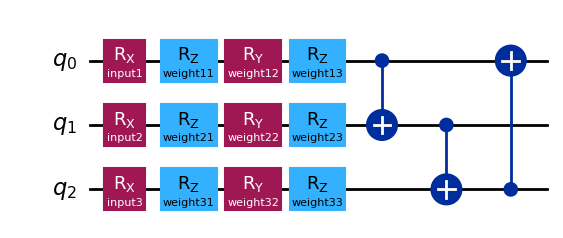

In [ ]:
pqn = PQN(
    qubits=3, repetitions=1
)
pqnn = pqn.create_qnn()
pqnn.circuit.draw(output="mpl")

In [ ]:
class HPQN(nn.Module):

  def __init__(self, input_size, layer_sizes=[5, 2, 1], qubits=5, repetitions=1, num_qlayers=1):
    super().__init__()

    #quantum layers
    pqn = PQN(
      qubits=qubits, repetitions=repetitions
    )
    self.qnn = nn.ModuleList()
    for i in range(num_qlayers):
      self.qnn.append(TorchConnector(pqn.create_qnn()))

    #FCNN before quantum layer
    self.preqNet = nn.Sequential(
        nn.Linear(input_size, qubits*num_qlayers),
        nn.ReLU()
    )

    #FCNN after quantum layer
    layers = [nn.Linear(qubits*num_qlayers, layer_sizes[0])]
    for l in range(len(layer_sizes)-1):
      layers.append(nn.ReLU())
      layers.append(nn.Linear(layer_sizes[l], layer_sizes[l+1]))
    self.postqNet = nn.Sequential(*layers)

  def forward(self, x):

    x = self.preqNet(x)
    #quantum layers

    xs = torch.split(x, self.qnn[0].neural_network.num_inputs, dim=1)
    x = []
    for c in range(len(xs)):
      x.append(self.qnn[c](xs[c]))
    x = torch.cat(x, dim=1)

    #x = self.qnn[0](x)
    x = self.postqNet(x)
    return x

#QDI

In [ ]:
class QDI():

    def __init__(self, qubits=8, repetitions1=1, repetitions2=1, depth=1, inputs=None, weights=None):

        if inputs is not None and len(inputs) != qubits:
          raise ValueError('Number of inputs doesnt align with number of qubits')

        self.qubits = qubits
        self.reps1 = repetitions1
        self.reps2 = repetitions2
        self.depth = depth

        self.weights = weights
        self.inputs = inputs
        self.gen_params()
        self.circuit = None
        self.gen_circuit()

        if self.weights is None or self.inputs is None or self.circuit is None:
          raise AttributeError('Weights, inputs or circuit is None')

    def gen_params(self):
      self.inputs = [Parameter("input" + str(i)) for i in range(1, self.qubits+1)] if self.inputs is None else self.inputs
      #self.weights = [[Parameter("weight" + str(j) + str(i)) for i in range(1, 3*self.reps+1)] for j in range(1, self.qubits+1)] if self.weights is None else self.weights
      self.weights = [[Parameter("weight" + str(j) + str(i)) for i in range(1, self.reps1+self.reps2*self.depth+1)] for j in range(1, self.qubits+1)] if self.weights is None else self.weights

    def gen_circuit(self):
      qc = QuantumCircuit(self.qubits)

      weight_index = 0
      #first layer of weighed gates
      for r in range(self.reps1):
        for q in range(self.qubits):
          qc.rx(self.weights[q][weight_index], q)

        #apply cnot gates
        for q in range(self.qubits-1):
          qc.cx(q, q+1)
        qc.cx(self.qubits-1, 0)
        weight_index += 1

      #encoding and weighed gates
      for d in range(self.depth):
        for q in range(self.qubits):
          qc.rz(self.inputs[q], q)
        for r in range(self.reps2):
          for q in range(self.qubits):
            qc.rx(self.weights[q][weight_index], q)

          #apply cnot gates
          for q in range(self.qubits-1):
            qc.cx(q, q+1)
          qc.cx(self.qubits-1, 0)
          weight_index += 1

      #ending cnot gates
      for q in range(1, self.qubits):
        qc.cx(q, 0)

      self.circuit = qc

    def create_qnn(self):

      observable = SparsePauliOp('Z' + 'I'*(self.qubits-1))
      return EstimatorQNN(
          circuit=self.circuit,
          input_params=self.inputs,
          weight_params=list(np.array(self.weights).flatten()),
          observables=observable,
          input_gradients=True
      )



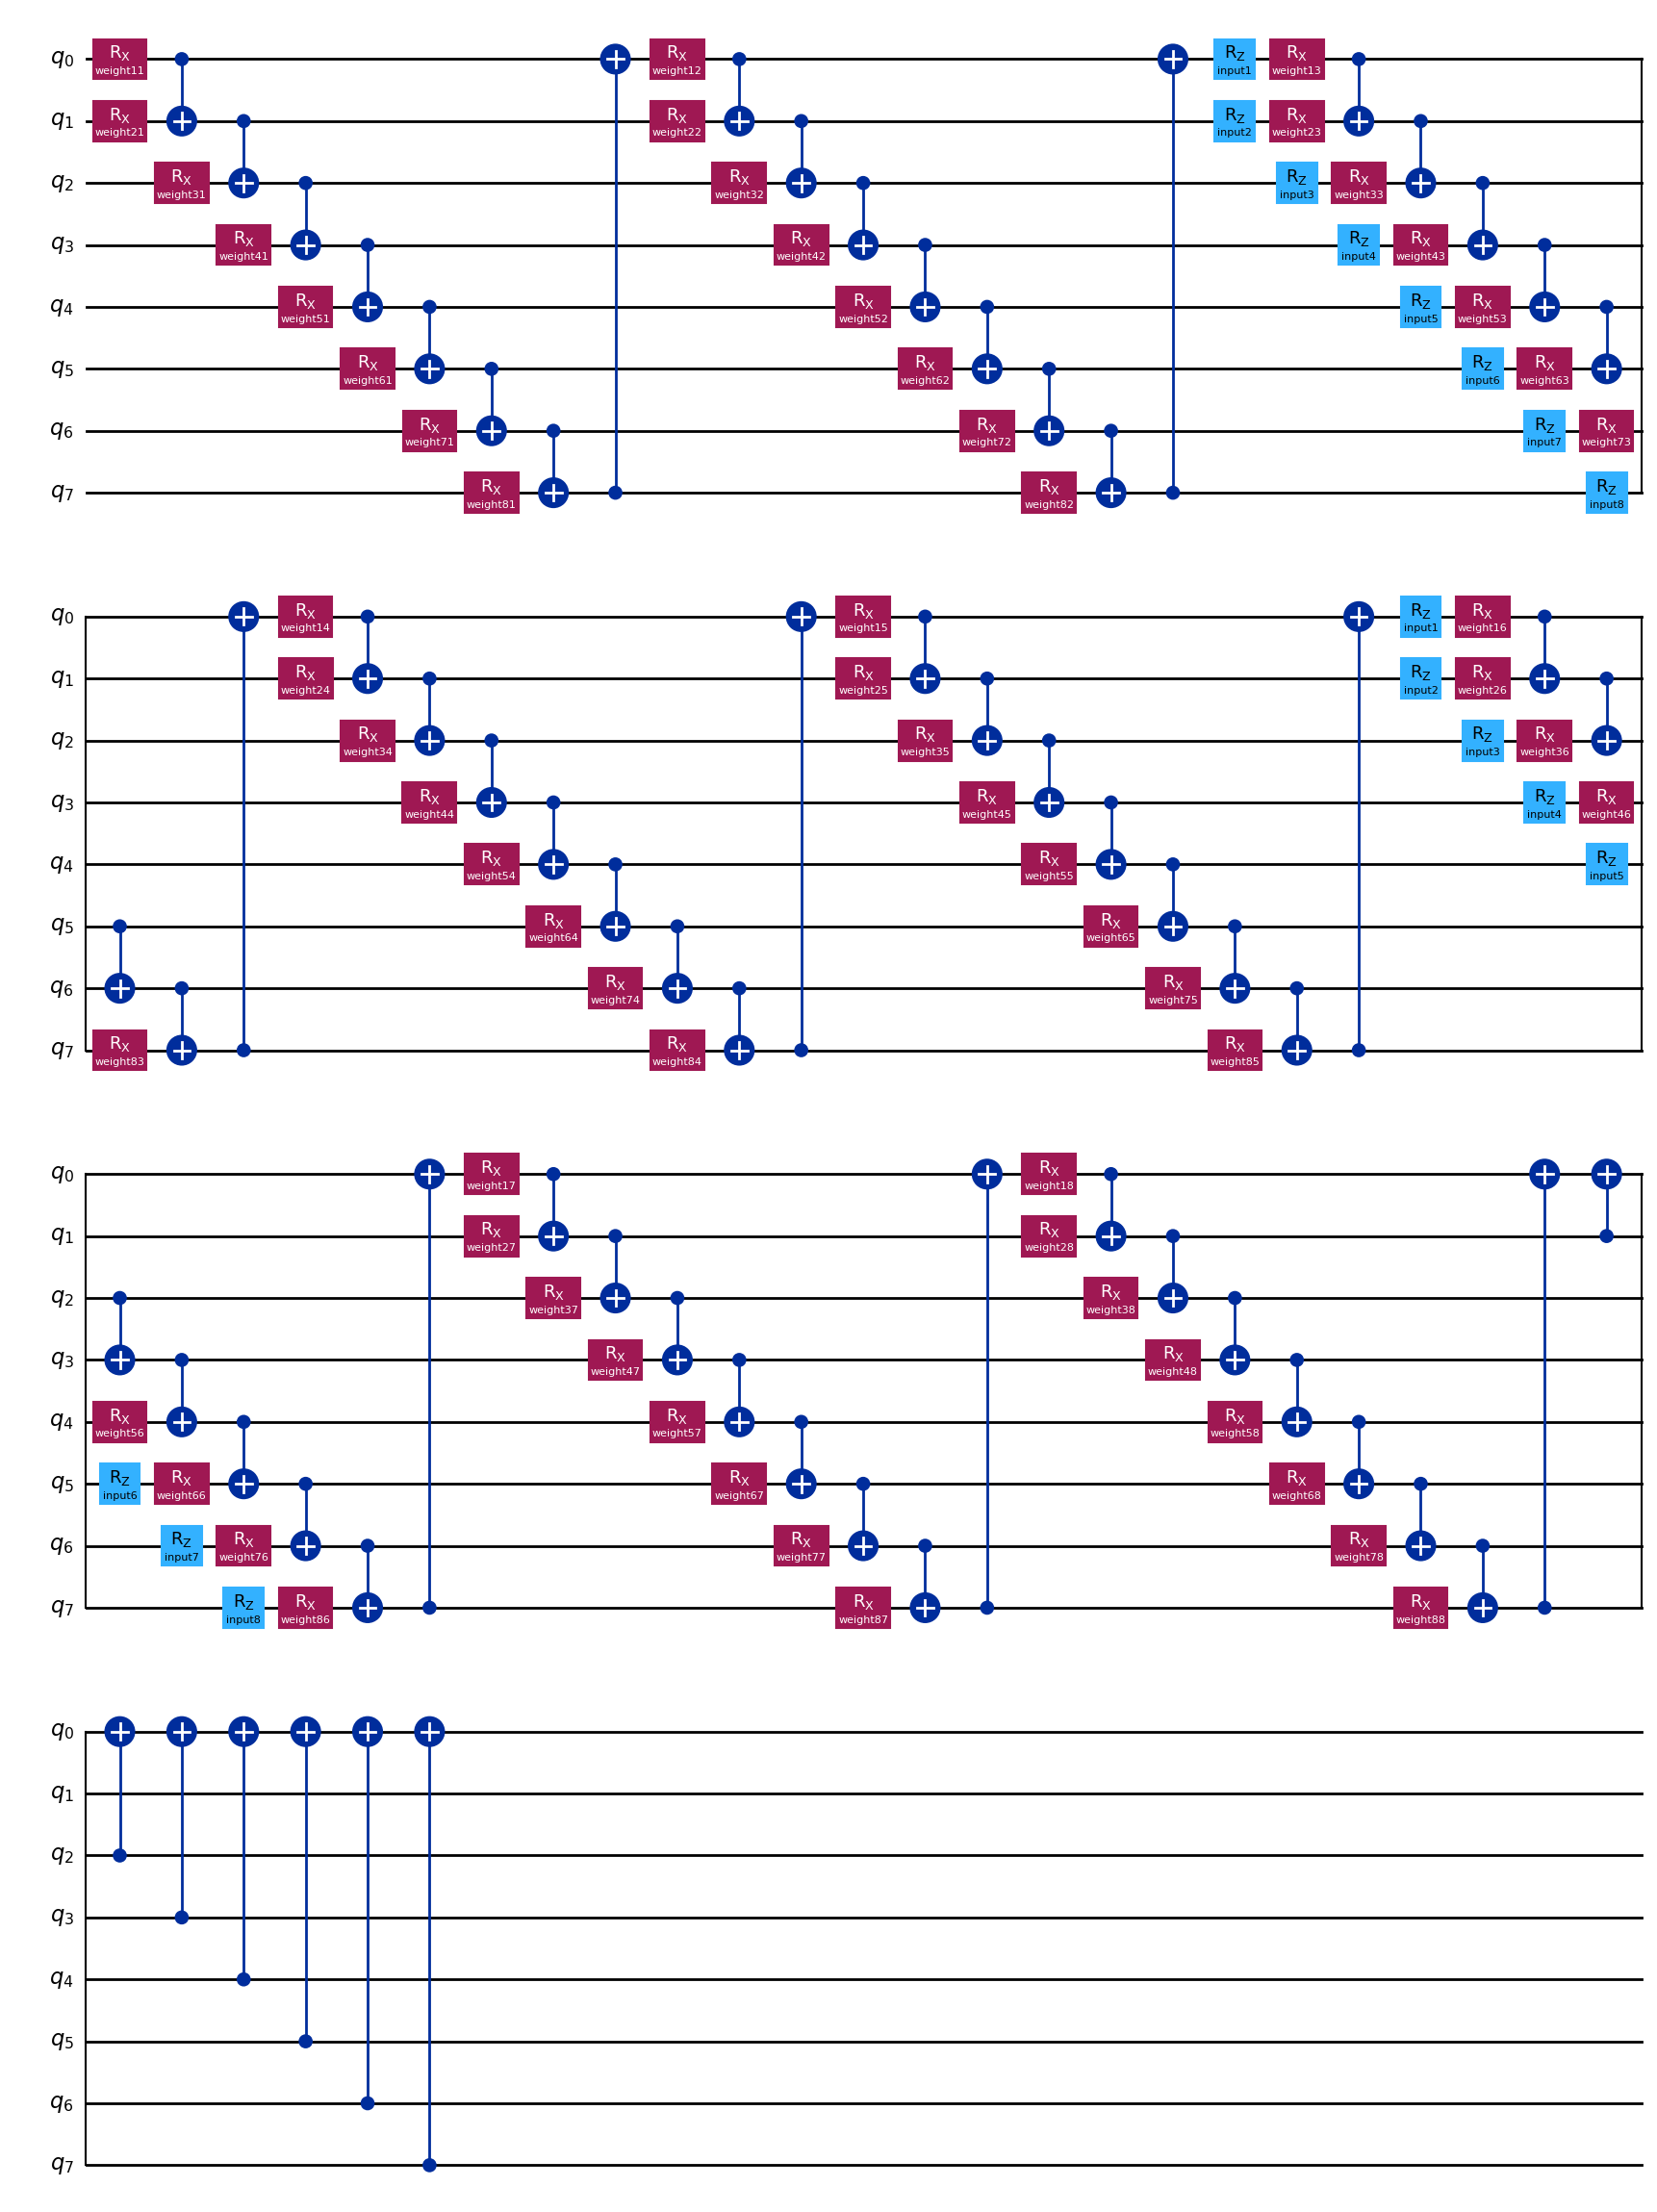

In [ ]:
qdi = QDI(
    repetitions1=2, repetitions2=3, depth=2
)
qdi.circuit.draw(output="mpl", justify="right")

In [ ]:
class QDINet(nn.Module):

  def __init__(self, input_size, layer_sizes=[10], qubits=8, qnn_params = (1, 1, 1)): #qnn_params = (rep1, rep2, depth)
    super().__init__()

    #quantum layers
    qdi = QDI(
      qubits=qubits, repetitions1=qnn_params[0], repetitions2=qnn_params[1], depth=qnn_params[2]
    )
    self.qnn = TorchConnector(qdi.create_qnn())

    #FCNN entrance layer
    layer_sizes.append(qubits)
    layers = [nn.Linear(input_size, layer_sizes[0])]
    for l in range(len(layer_sizes)-1):
      layers.append(nn.ReLU())
      layers.append(nn.Linear(layer_sizes[l], layer_sizes[l+1]))
    self.fcnn = nn.Sequential(*layers)

  def forward(self, x):
    x = self.fcnn(x)
    x = self.qnn(x)
    return x

# EFQ

In [10]:
class EFQ():

    def __init__(self, qubits, repetitions, inputs=None, weights=None):

        if inputs is not None and len(inputs) != qubits:
          raise ValueError('Number of inputs doesnt align with number of qubits')

        self.qubits = qubits
        self.reps = repetitions

        self.weights = weights
        self.inputs = inputs
        self.gen_params()
        self.circuit = None
        self.gen_circuit()

        if self.weights is None or self.inputs is None or self.circuit is None:
          raise AttributeError('Weights, inputs or circuit is None')

    def gen_params(self):
      self.inputs = [Parameter("input" + str(i)) for i in range(1, self.qubits+1)] if self.inputs is None else self.inputs
      self.weights = [[Parameter("weight" + str(j) + '_' + str(i)) for i in range(1, 6*(self.reps+1)+1)] for j in range(1, self.qubits+1)] if self.weights is None else self.weights

    def applyWGate(self, count):

      #first layer of rotation gates
      for q in range(self.qubits):
        self.circuit.rz(self.weights[q][count*6], q)
        self.circuit.ry(self.weights[q][count*6+1], q)
        self.circuit.rx(self.weights[q][count*6+2], q)

      #cnot gates
      for q in range(self.qubits-1):
        self.circuit.cx(q, q+1)
      if self.qubits > 2:
        self.circuit.cx(self.qubits-1, 0)

      #second layer of rotation gates
      for q in range(self.qubits):
        self.circuit.rz(self.weights[q][count*6+3], q)
        self.circuit.ry(self.weights[q][count*6+4], q)
        self.circuit.rx(self.weights[q][count*6+5], q)

    def gen_circuit(self):

      qc = QuantumCircuit(self.qubits)
      self.circuit = qc

      nWGates = 0

      #intro WGate
      self.applyWGate(nWGates)
      nWGates+=1

      for r in range(self.reps):

        #encoding
        self.circuit.rz(self.inputs[0], 0)
        for q in range(1, self.qubits):
          self.circuit.rz(self.inputs[q]*(2**(q-1)+1), q)

        #WGate
        self.applyWGate(nWGates)
        nWGates+=1

      #cnot gates
      for q in range(self.qubits-1, 0, -1):
        self.circuit.cx(q, 0)

    def create_qnn(self):

      observable = SparsePauliOp('Z' + 'I'*(self.qubits-1))
      return EstimatorQNN(
          circuit=self.circuit,
          input_params=self.inputs,
          weight_params=list(np.array(self.weights).flatten()),
          observables=observable,
          input_gradients=True
      )



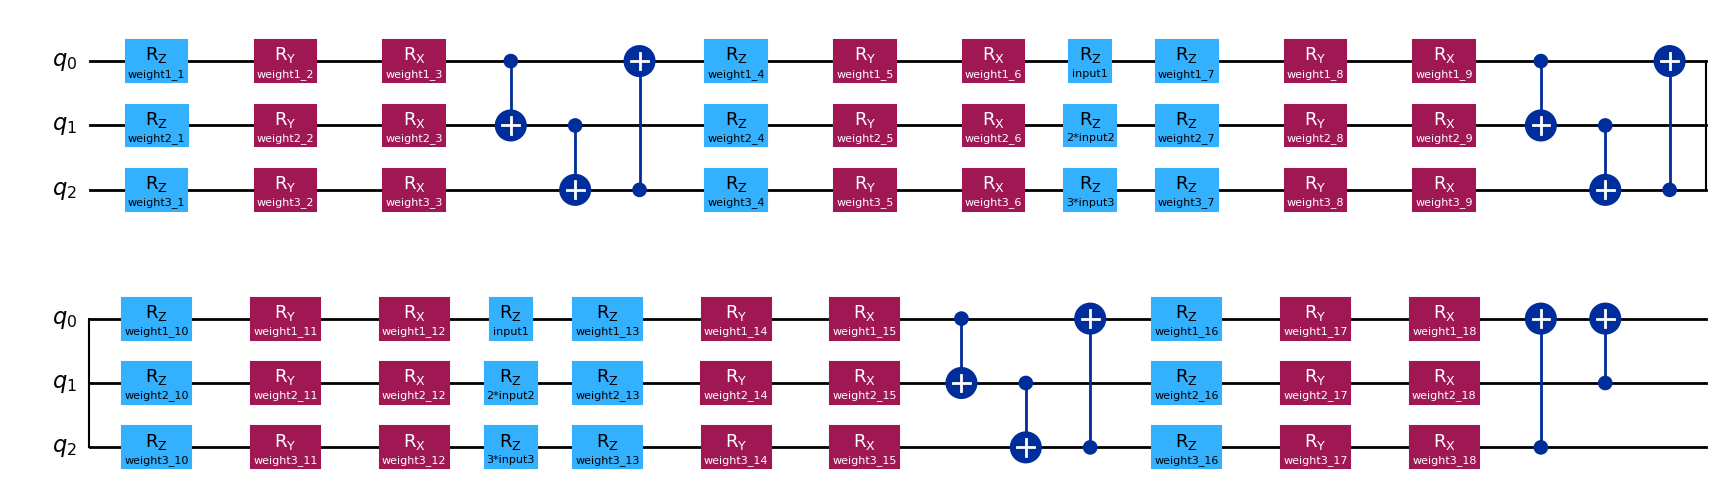

In [11]:
efq = EFQ(
    qubits=3, repetitions=2
)
efq.circuit.draw(output="mpl")

In [12]:
class EFQNet(nn.Module):

  def __init__(self, input_size, layer_sizes=[8, 4], qubits=2, repetitions=1):
    super().__init__()

    #quantum layer
    efq = EFQ(
      qubits=qubits, repetitions=repetitions
    )
    self.qnn = TorchConnector(efq.create_qnn())

    #FCNN entrance layer
    layer_sizes.append(qubits)
    layers = [nn.Linear(input_size, layer_sizes[0])]
    for l in range(len(layer_sizes)-1):
      layers.append(nn.ReLU())
      layers.append(nn.Linear(layer_sizes[l], layer_sizes[l+1]))
    self.fcnn = nn.Sequential(*layers)

  def forward(self, x):
    x = self.fcnn(x)
    x = self.qnn(x)
    return x

# Train Loop

In [15]:
def train(model, criterion, optimizer, trainDL, epochs=10):

  epoch_loss = []
  log_weights = []
  for epoch in tqdm(range(epochs)):

    batch_loss = 0
    #b=0
    for batch in trainDL:
      #b+=1
      X = batch[0].to(device)
      y = batch[1].to(device)

      # model forward-pass
      preds = model(X)

      # model backward-pass
      optimizer.zero_grad()
      loss = criterion(preds, y)
      loss_mean = loss.mean()
      #print('xd'+str(epoch)+str(b))
      loss_mean.backward()
      optimizer.step()

      # save loss and accuracy
      batch_loss += loss_mean.detach().cpu().numpy()
      #print(model.qnn[0].weight) #check if the parameters of HPQN are updated

    epoch_loss.append(batch_loss / len(trainDL))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, epoch_loss[-1]))

  return epoch_loss

# HPQN training and verification

In [ ]:
# Define model, optimizer, and loss function
hpqn = HPQN(
    input_size=10, qubits=5, num_qlayers=2
)
hpqn.to(device)

optimizer = optim.Adam(hpqn.parameters(), lr=0.01)
criterion = nn.L1Loss(reduction='none')
epochs = 10  # Set number of epochs
hpqn.train()  # Set model to training mode

HPQN(
  (qnn): ModuleList(
    (0-1): 2 x TorchConnector()
  )
  (preqNet): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (postqNet): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=2, bias=True)
    (3): ReLU()
    (4): Linear(in_features=2, out_features=1, bias=True)
  )
)

In [ ]:
log_weights = train(
    model=hpqn,
    criterion=criterion,
    optimizer=optimizer,
    trainDL=HMtrainDL,
    epochs=epochs
)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Training [10%]	Loss: 0.9983
Training [20%]	Loss: 0.9984


KeyboardInterrupt: 

# QDI Network training and verification

In [ ]:
# Define model, optimizer, and loss function
qdinet = QDINet(
    input_size=10
)
qdinet.to(device)

optimizer = optim.Adam(qdinet.parameters(), lr=0.01)
criterion = nn.L1Loss(reduction='none')
epochs = 10  # Set number of epochs
qdinet.train()  # Set model to training mode

QDINet(
  (qnn): TorchConnector()
  (fcnn): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=8, bias=True)
  )
)

In [ ]:
total_loss = train(
    model=qdinet,
    criterion=criterion,
    optimizer=optimizer,
    trainDL=HMtrainDL,
    epochs=epochs
)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Training [10%]	Loss: 0.9997
Training [20%]	Loss: 0.9994
Training [30%]	Loss: 0.9991
Training [40%]	Loss: 0.9991
Training [50%]	Loss: 0.9992


# EFQ Network training and verification

In [13]:
# Define model, optimizer, and loss function
efqnet = EFQNet(
    input_size=10
)
efqnet.to(device)

optimizer = optim.Adam(efqnet.parameters(), lr=0.01)
criterion = nn.L1Loss(reduction='none')
epochs = 10  # Set number of epochs
efqnet.train()  # Set model to training mode

EFQNet(
  (qnn): TorchConnector()
  (fcnn): Sequential(
    (0): Linear(in_features=10, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=2, bias=True)
  )
)

In [18]:
total_loss = train(
    model=efqnet,
    criterion=criterion,
    optimizer=optimizer,
    trainDL=HMtrainDL,
    epochs=epochs
)

  0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Training [10%]	Loss: 1.0054
Training [20%]	Loss: 1.0015
Training [30%]	Loss: 0.9992
Training [40%]	Loss: 0.9998
Training [50%]	Loss: 0.9976
Training [60%]	Loss: 0.9964
Training [70%]	Loss: 0.9970
Training [80%]	Loss: 0.9961
Training [90%]	Loss: 0.9972
Training [100%]	Loss: 0.9961
